In [25]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import matplotlib.pyplot as plt
from bicycle.utils.mask_utils import get_sparsity, above_threshold, string_to_list
import json
from glob import glob
from scipy.special import expit

In [27]:
save = False

In [28]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    if len(params)>4:
        params["pert. factor"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. factor"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. factor"
    params=params.sort_values(param_of_interest)
    return params, param_of_interest
def agg6(params, param_of_interest):
    params[param_of_interest] = params[param_of_interest].astype(float)
    params = params.sort_values(param_of_interest)
    return params, param_of_interest
def agg7(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla_old","Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg8(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params["data_id"]+params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
    "agg7":agg7,
    "agg8":agg8,
             }

In [29]:
# get environment
with open("./data/experiment_configs.json", "r") as rf:
    config_sets = json.load(rf)

config_set = config_sets[-1]
include = config_set["include"]
id_len = config_set["id_len"]
prefix = config_set["prefix"]
experiment = config_set["experiment"]
param_of_interest = config_set["param_of_interest"]
agg = config_set["function"]

#include = np.array([32,33])
#id_len = 5
#prefix = "test_run_"
#experiment = None
#param_of_interest = "masking_mode"
#agg = None
print(f"Experiment: {experiment}")
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
     "model_lr",
     "model_n_genes",
     "model_n_samples",
     "model_gt_interv",
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_id"
    ]
if not param_of_interest in columns:
    columns.append(param_of_interest)
    print(f"Adding {param_of_interest}")
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    if int(dir.name[-id_len:]) not in include:
          continue
    print(dir.name)
    if (dir/ "manual_globals.csv").exists():
        params.loc[dir.name] = np.nan
        p = pd.read_csv(dir/"manual_globals.csv", index_col=0)
        available_paras=[n for n in params.columns if n in p.columns]
        params.loc[dir.name, available_paras] = p.loc[dir.name,available_paras]
        continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan
if experiment == "scalemask":
     params = pd.read_csv(models_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")
    
if agg != None:
     params, param_of_interest = functions[agg](params, param_of_interest)
#params = pd.read_csv(models_path.parent/"manual_params.csv", index_col=0).sort_index()
#add = "test_run_00025"
#available_paras=[n for n in params.columns if n in params1.columns]
#params.loc[add, available_paras] = params1.loc[add,available_paras]

Experiment: eigenvalues_scm
Adding run_id
run_055
run_043
run_053
run_042
run_052
run_054


In [30]:
ckpts = dict()
for path in models_path.iterdir():
    key = str(path.name)
    if path.name[:-id_len] != prefix:
         continue
    if int(path.name[-id_len:]) not in include:
          continue
    paths = glob(root_dir=path/"customcheckpoint", pathname="./last*.ckpt")
    try:
        paths.remove('./last.ckpt')
    except:
        print(f"{key} has no last.ckpt")
        params = params.drop(index=key)
        continue

    if len(paths) ==0:
        print("using last")
        ckpt_path = path / "customcheckpoint/last.ckpt"
        if not ckpt_path.exists():
            params = params.drop(index=key)

            continue
    else:
        ckpt_path = path / "customcheckpoint"/ max(paths)
        print(ckpt_path)
    print(key)
    state = torch.load(ckpt_path, weights_only=False, map_location="cpu")
    print("last epoch: ",state["epoch"])
    if state["epoch"]<500:
         print(f"{key} only has {state['epoch']} epoch.\nWill be removed...")
         params = params.drop(index=key)
         continue
    ckpts[str(path.name)] = {}
    grn = state["hyper_parameters"]["gt_beta"]
    if type(grn) != np.ndarray:
         grn = grn.numpy()
    ckpts[str(path.name)]["grn"] = grn
    if not state["hyper_parameters"]["mask"] is None:
            beta = np.zeros(grn.shape)
            beta[state["hyper_parameters"]["mask"].to(bool)] = state["state_dict"]["beta_val"].numpy()
            ckpts[str(path.name)]["beta"] = beta
    else:
        ckpts[str(path.name)]["beta"] = state["state_dict"]["beta"].numpy()
    prior = state["hyper_parameters"].get("bayes_prior", None)
    if not prior is None:
        ckpts[str(path.name)]["prior"] = prior.numpy()


using last
run_055
last epoch:  9875
using last
run_043
last epoch:  9999
using last
run_053
last epoch:  9999
using last
run_042
last epoch:  9999
using last
run_052
last epoch:  9999
using last
run_054
last epoch:  9927


In [31]:
params

,model_lr,model_n_genes,model_n_samples,model_gt_interv,pretraining_time,training_time,compile,trad_loading,scale_mask,grn_noise_p,n_epochs,use_hard_mask,masking_mode,bin_prior,data_id,run_id
run_042,0.001,10,20400,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",617.9653899669647,5419.139075517654,True,True,0.1,NaN,10000,False,NaN,False,data_run000,run_042
run_043,0.001,10,20400,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",649.3287177085876,5537.878669023514,True,True,0.1,0.32,10000,False,loss,False,data_run000,run_043
run_052,0.001,20,12000,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",572.1446497440338,6647.070095539093,True,True,0.1,NaN,10000,False,NaN,False,data_run010,run_052
run_053,0.001,20,12000,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",539.9088759422302,6592.091732263565,True,True,0.1,0.055,10000,False,loss,False,data_run010,run_053
run_054,0.001,20,12000,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",566.0237195491791,6499.364449262619,True,True,0.1,NaN,10000,False,NaN,False,data_run011,run_054
run_055,0.001,20,12000,"tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0...",569.0329520702362,6563.998987913132,True,True,0.1,0.05,10000,False,loss,False,data_run011,run_055


In [8]:
n = 1
if param_of_interest != "run_id":
    while params[param_of_interest].duplicated().any():
        params.loc[params[param_of_interest].duplicated(), param_of_interest] += f"."
        n+=1
params

KeyboardInterrupt: 

No prior
No prior
No prior


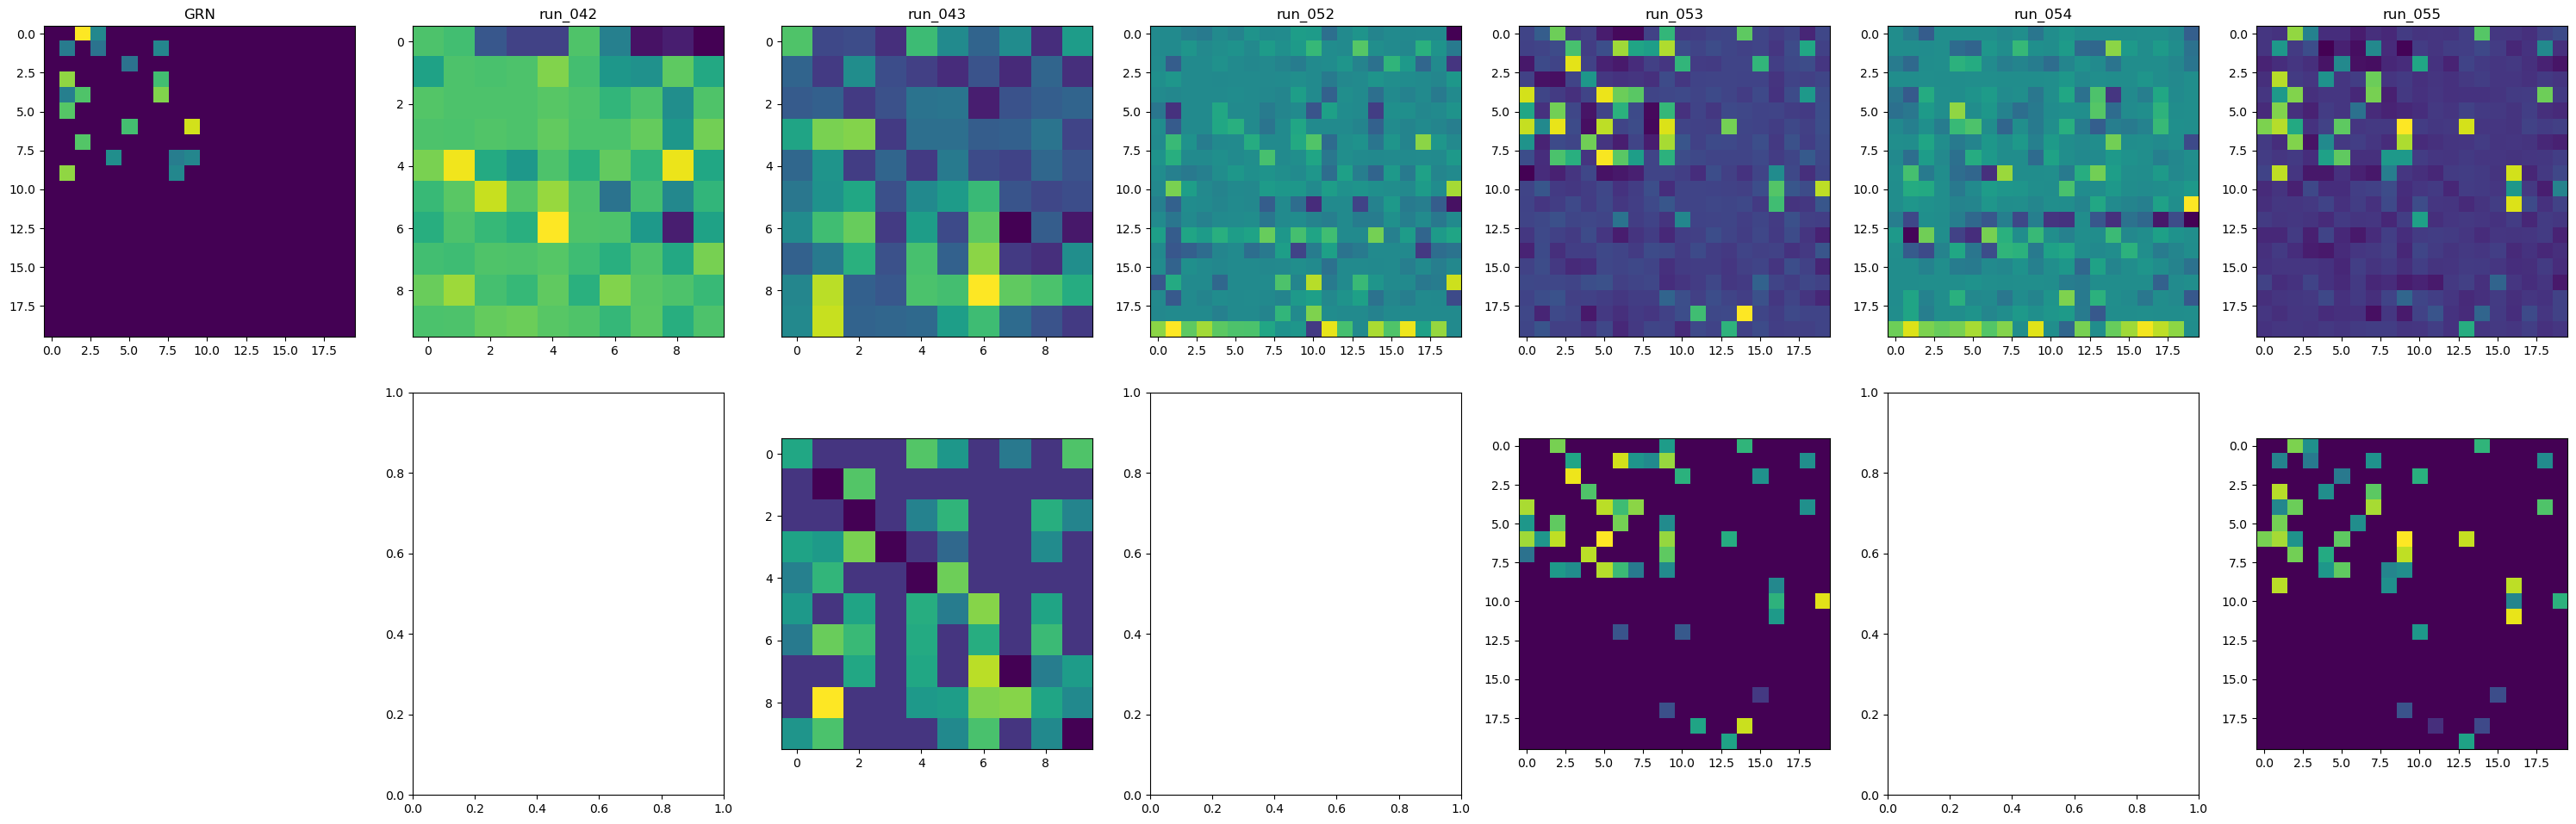

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=len(params)+1, figsize = (30, 10))
ax[0, 0].imshow(grn)
ax[0, 0].set_title("GRN")
for n, run_id in enumerate(params.index):
    ax[0, n+1].imshow(ckpts[run_id]["beta"])
    ax[0, n+1].set_title(params.loc[run_id,param_of_interest])
    try:
        ax[1, n+1].imshow(ckpts[run_id]["prior"])
    except KeyError:
        print("No prior")
fig.delaxes(ax[1,0])
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    if len(params)>4:
        params["pert. factor"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. factor"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. factor"
    params=params.sort_values(param_of_interest)
    return params, param_of_interest
def agg6(params, param_of_interest):
    params[param_of_interest] = params[param_of_interest].astype(float)
    params = params.sort_values(param_of_interest)
    return params, param_of_interest
def agg7(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla_old","Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg8(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params["data_id"]+params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
    "agg7":agg7,
    "agg8":agg8,
             }
fig.tight_layout()

run_042
percentile threshold for run_042 is 80
run_043
percentile threshold for run_043 is 80
run_052
percentile threshold for run_052 is 80
run_053
percentile threshold for run_053 is 80
run_054
percentile threshold for run_054 is 80
run_055
percentile threshold for run_055 is 80


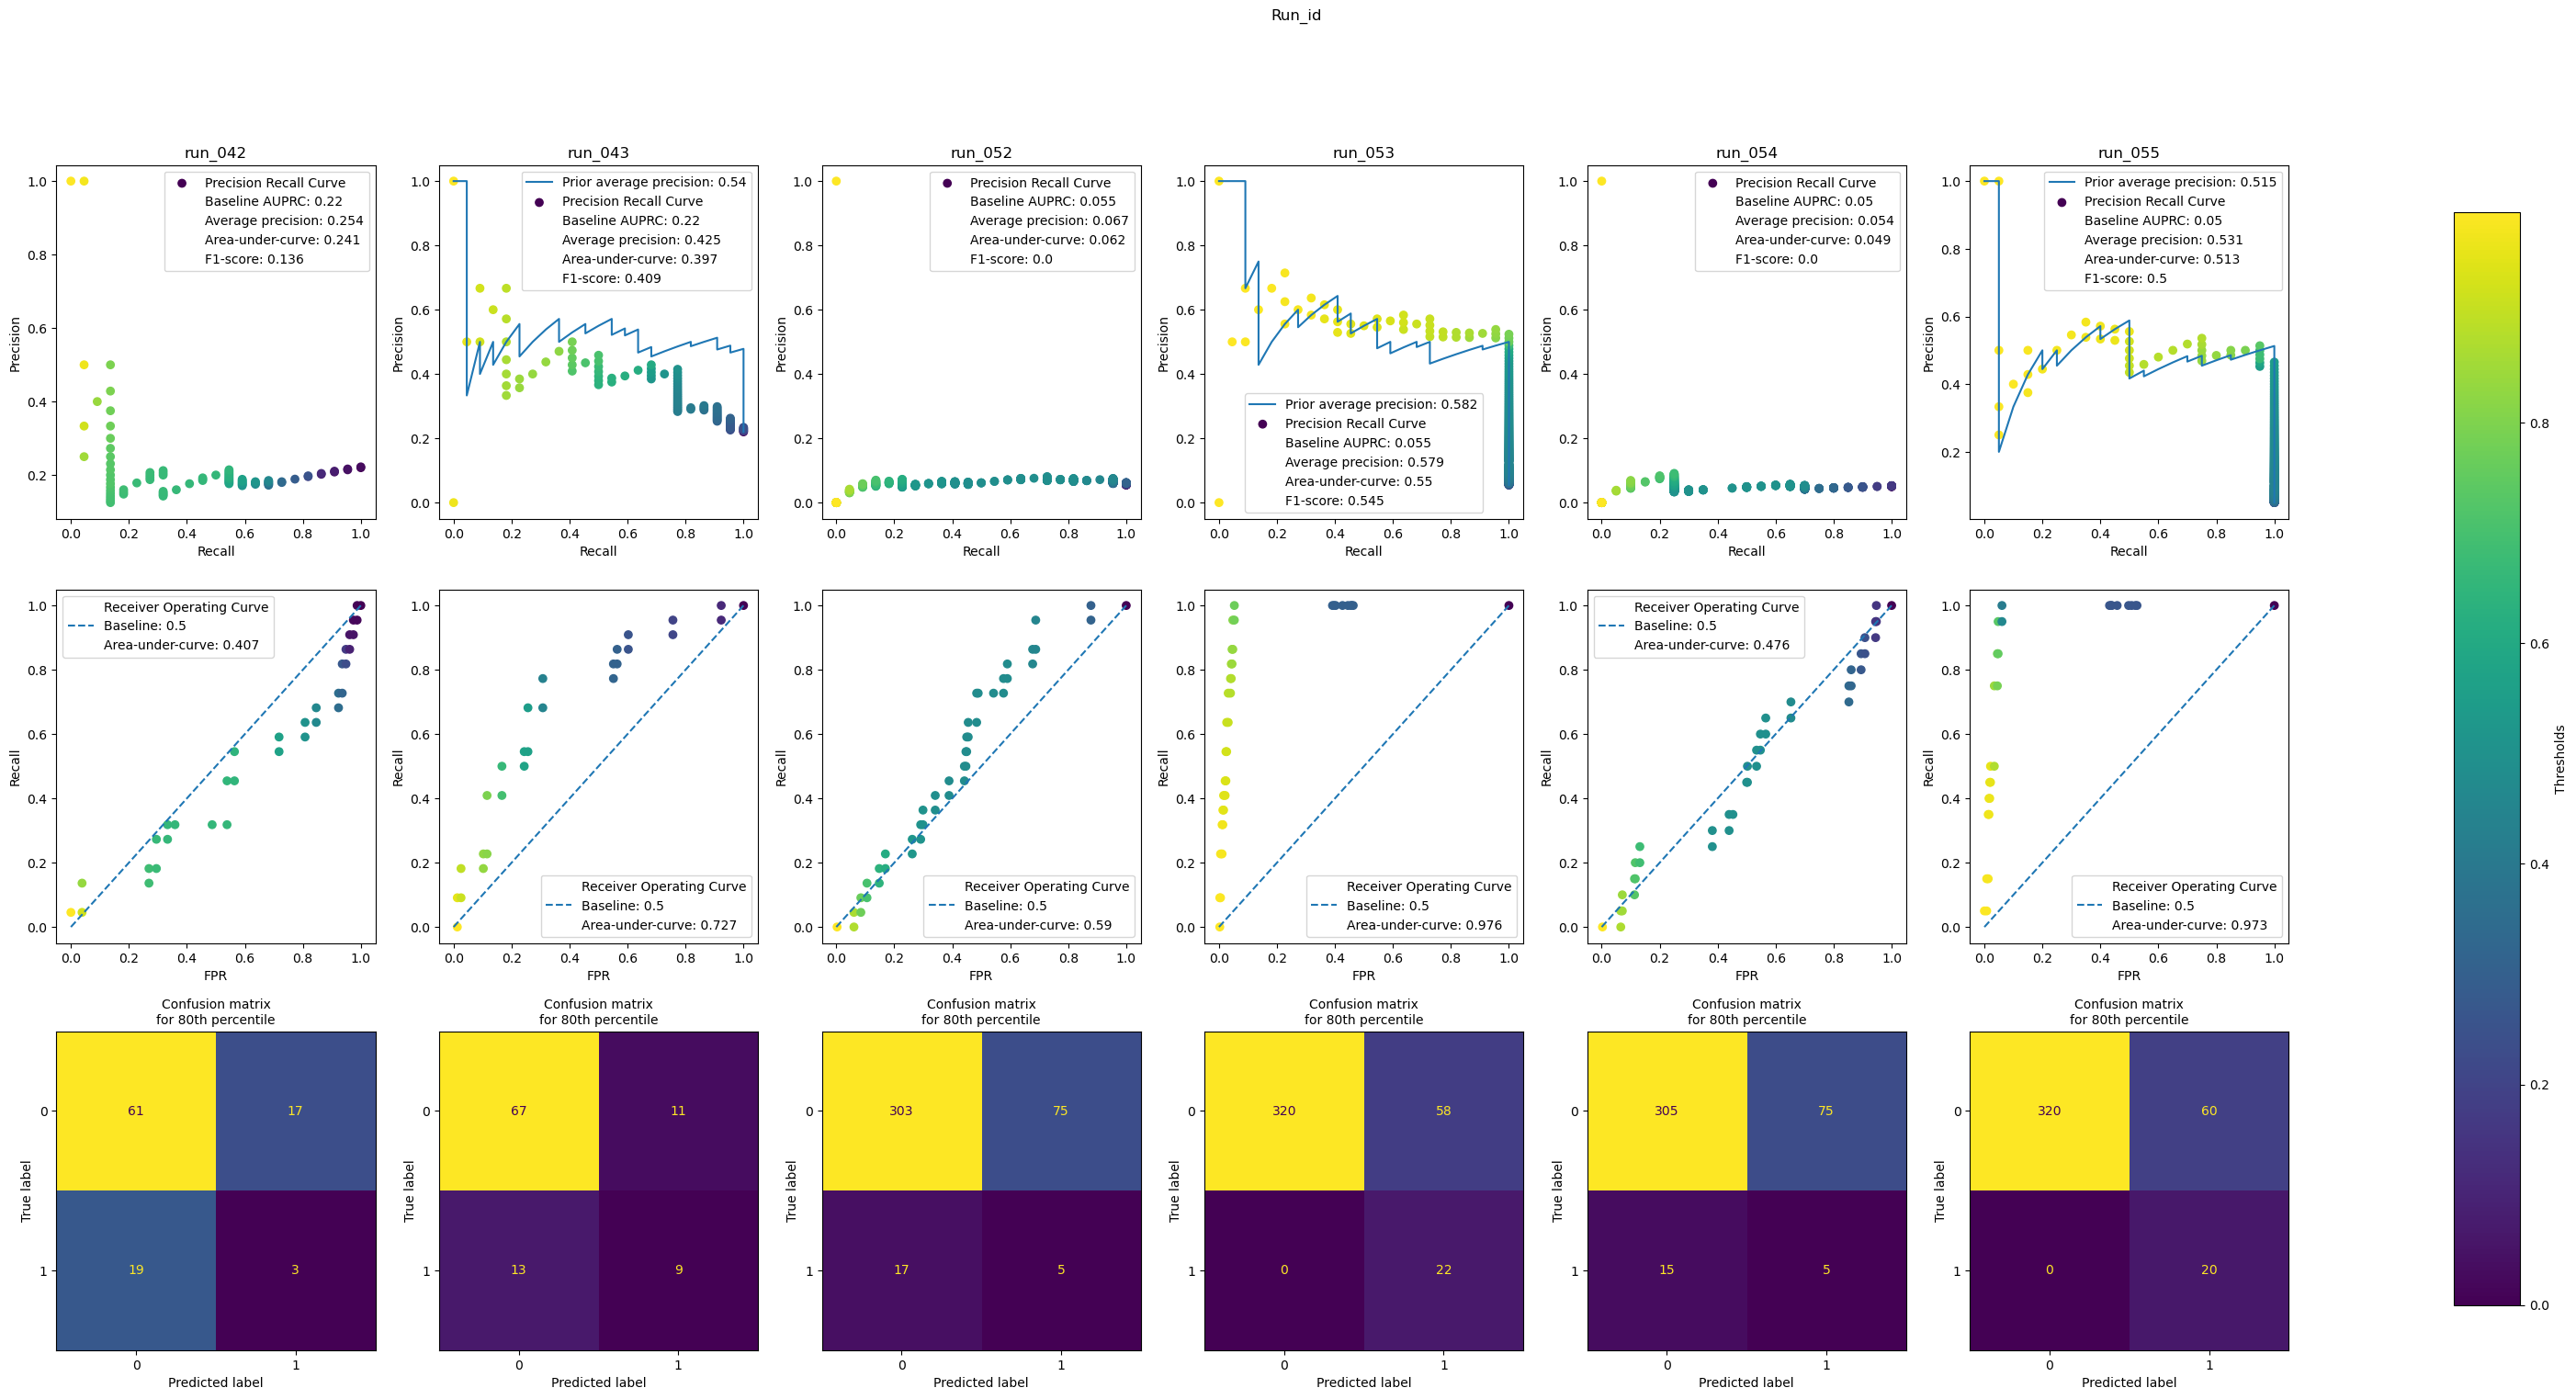

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=len(ckpts.keys()), figsize=(len(ckpts.keys())*6, 17))

params["average_precision"] = np.empty(len(params))
params["auprc"] = np.empty(len(params))
params["f1"] = np.empty(len(params))
params["auroc"] = np.empty(len(params))



for n, run_id in enumerate(params.index):
    max_f1 = False

    print(run_id)
    beta = ckpts[run_id]["beta"]
    grn = ckpts[run_id]["grn"]
    grn = grn.flatten()
    beta = beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    #beta[beta < 0] = 0
    # center and scale beta
    beta = beta-np.mean(beta)
    beta = beta/np.std(beta)
    beta = expit(beta)
    precision, recall, prc_thresholds = precision_recall_curve(
        y_true=grn,
        y_score=beta,
    )
    if "prior" in ckpts[run_id].keys():
        prior = ckpts[run_id]["prior"]
        prior = prior.flatten()
        prior[prior < 0] = 0
        prior = expit(prior)
        prior_precision, prior_recall,_ = precision_recall_curve(
            y_true=grn,
            y_score=prior,
        )
        ax[0, n].plot(prior_recall, prior_precision, label= f"Prior average precision: {np.round(average_precision_score(y_true=grn,y_score= prior),3)}")
        #ax[0,n].plot([], [], " ", label= f"Prior average precision: {np.round(average_precision_score(y_true=grn,y_score= prior),3)}")
    # baseline is positive samples/total samples (saito et al.) = sparsity
    baseline_AUPRC = get_sparsity(ckpts[run_id]["grn"])
    ConfusionMatrixDisplay.from_predictions(
        y_true=grn,
        y_pred=above_threshold(beta, percentile=80),
        ax=ax[2, n],
        colorbar=False
    )
    print(f"percentile threshold for {run_id} is {80}")
    ax[2, n].set_title("Confusion matrix\nfor 80th percentile", fontsize = 10)
    if max_f1:
        f1_scores = [f1_score(grn, above_threshold(beta, threshold=threshold)) for threshold in prc_thresholds]
        max_f1 = max(f1_scores)
    else:
        max_f1 = f1_score(grn, above_threshold(beta, percentile=100-baseline_AUPRC*100))

    auprc = auc(x=recall, y=precision)
    average_precision = average_precision_score(grn, beta)
    im = ax[0, n].scatter(recall, precision, label="Precision Recall Curve", c=np.append(0, prc_thresholds), cmap=plt.colormaps["viridis"])
    ax[0, n].plot([], [], " ", label=f"Baseline AUPRC: {np.round(baseline_AUPRC, 3)}")
    ax[0, n].plot([], [], " ", label=f"Average precision: {np.round(average_precision, 3)}")
    ax[0, n].plot([], [], " ", label=f"Area-under-curve: {np.round(auprc, 3)}")
    ax[0, n].plot([], [], " ", label=f"F1-score: {np.round(max_f1, 3)}")

    ax[0, n].set_ylabel("Precision")
    ax[0, n].set_xlabel("Recall")

    if not isinstance(params.loc[run_id, param_of_interest], str):
        ax[0, n].set_title(f"{round(float(params.loc[run_id, param_of_interest]), 3)}")
    else:
        ax[0, n].set_title(f"{params.loc[run_id, param_of_interest]}")
        #ax[0, n].set_title(key)
    ax[0, n].legend()

    fpr, tpr, roc_thresholds = roc_curve(y_true=grn, y_score=beta)
    auroc = auc(fpr, tpr)
    ax[1, n].scatter(fpr, tpr, label="Receiver Operating Curve", c=roc_thresholds, cmap=plt.colormaps["viridis"])
    ax[1, n].plot([0, 1], [0, 1], "--", label="Baseline: 0.5")
    ax[1, n].plot([], [], " ", label=f"Area-under-curve: {np.round(auroc, 3)}")

    ax[1, n].set_ylabel("Recall")
    ax[1, n].set_xlabel("FPR")
    ax[1, n].legend()

    params.loc[run_id, "average_precision"] = average_precision
    params.loc[run_id, "auprc"] = auprc
    params.loc[run_id, "f1"] = max_f1
    params.loc[run_id, "auroc"] = auroc
fig.suptitle(f"{param_of_interest.capitalize()}")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes((0.85, 0.15, 0.02, 0.7))
fig.colorbar(im, cax=cbar_ax, label="Thresholds")
#fig.tight_layout()
if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_metrics_curves.pdf", bbox_inches="tight", pad_inches=0)

Saving!


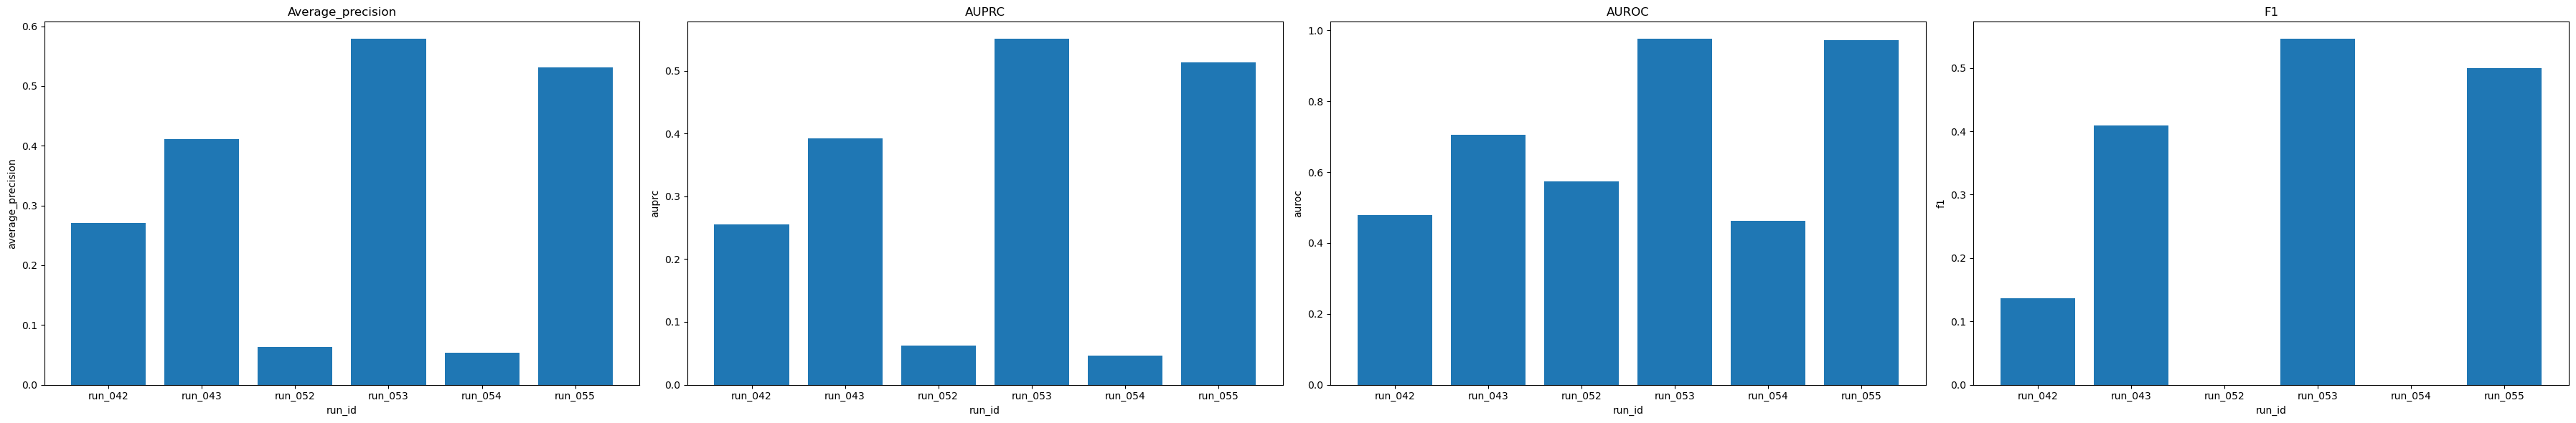

In [24]:
scale_width = 0.5
if not type(params.loc[run_id, param_of_interest]) is float:
    scale_width=1
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(len(ckpts.keys())*len(params)*scale_width, 6*scale_width))
ax = ax.flatten()
for n, metric in enumerate(["average_precision","auprc","auroc", "f1"]):
    if not type(params.loc[run_id, param_of_interest]) is float or params.loc[run_id, param_of_interest] is np.nan:
        ax[n].bar(params[param_of_interest].astype(str),
                  params[metric])
    else:
        ax[n].bar(np.round(params[param_of_interest].astype(float), 3).astype(str), params[metric])
    if "_" in metric:
        ax[n].set_title(metric.capitalize())
    else:
        ax[n].set_title(metric.upper())
    ax[n].set_ylabel(metric)
    ax[n].set_xlabel(param_of_interest)
fig.tight_layout()
if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_metrics_bar.pdf", bbox_inches = "tight", pad_inches = 0)